# Data analysis with XGBoost (Company motorbikes registrations in Bohemia example)

This notebook demontrates how to:
1. load data from Extera Feature Store
2. feature engineering for xgboost model
3. find optimal hyperparameters for model using cross validation
4. train model
5. explain model feature importance with eli5 and shap

Corresponding article: [https://www.mindforce.ai/post/jak%C3%A9-firmy-si-v-%C4%8Dr-kupuj%C3%AD-motorky-a-jak-je-naj%C3%ADt-s-pomoci-ai](https://www.mindforce.ai/post/jak%C3%A9-firmy-si-v-%C4%8Dr-kupuj%C3%AD-motorky-a-jak-je-naj%C3%ADt-s-pomoci-ai)

## Set Up

1. Install pandas, sklearn and xgboost

In [1]:
# data load & preparation
import pandas as pd
from sklearn.model_selection import train_test_split
# data model
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report 
# model explain
import shap
import matplotlib.pyplot
# from pandas_profiling import ProfileReport

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.set_option('display.max_rows', 1000)

## Load data from Extera Feature Store


In [3]:
moto_data_query = '''
--26k records for 11k entrepreneurs, 16k companies 
with vozidla_L as
  (
  SELECT 
  fsob.* except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky, vhcl_flag),
  if(vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky>0,1,0) as moto_class_target
  FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
  inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
  where fsob.sid in
    (
    select distinct owner_sid from `steady-vine-203410.nexus.vehicle_registration` vr 
    where vr.vehicle_category_code in ('L') --  motorbikes
    )
  and org.abolishment_date = '9999-12-31' -- companies/entrepreneurs still alive
  )
/*11 *5 = 55k sample entrepreneurs*/
, non_L_sample_ent as
  (
  select
  fsob.* except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky, vhcl_flag),
  0 as moto_class_target
  FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
  inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
  where fsob.sid not in (select sid from vozidla_L) 
  -- minimum record quality requirements
  and org.region is not null 
  and org.nace_level_2 is not null
  and org.abolishment_date = '9999-12-31'
  and org.interruption_date is null
  and org.ent_flag = 'Y'
  order by sid desc # = by hash = random
  limit 55000
)
, non_L_sample_comp as
  (
  select
  fsob.* except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky,  vhcl_flag),
  0 as moto_class_target
  FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
  inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
  where fsob.sid not in (select sid from vozidla_L) 
  -- minimum record quality requirements
  and org.region is not null 
  and org.nace_level_2 is not null
  and org.abolishment_date = '9999-12-31'
  and org.turnover_category_code is not null
  and org.ent_flag = 'N'
  order by sid desc # = by hash = random
  limit 80000
)
select * except (sid) from vozidla_L
union all
select * except (sid) from non_L_sample_ent
union all
select * except (sid) from non_L_sample_comp
'''

moto_model_data = pd.read_gbq(project_id='steady-vine-203410',query = moto_data_query)

## Data preparation & feature engineering for xgboost model

categorical data in nexus feature store:
1. are already one-hot encoded 
2. nulls are handled where possible

but still contain outliers that need to be handled on selected data subset  - in this examle replace with MEAN+-3STD tresholds

data normalization is not necessary for xgboost algoritm

In [15]:
# delete records with extreme values
moto_model_data_cln = moto_model_data[
    ((moto_model_data['assets'].abs() < 1000000000) | (moto_model_data['assets'].isna()))
    &((moto_model_data['profit_change'].abs()<10000) | (moto_model_data['profit_change'].isna()))
    &((moto_model_data['assets_change'].abs()<10000) | (moto_model_data['assets_change'].isna()))
    &((moto_model_data['net_turnover_change'].abs()<10000) | (moto_model_data['net_turnover_change'].isna()))
    ]

# calculate the limits and check outlier counts
col_names = ['col','lower_treshold','upper_treshold','min','lower_outlier_cnt','max','upper_outlier_cnt']
outlier_columns = pd.DataFrame(columns=col_names)
for col in moto_model_data_cln.columns:
    if ((moto_model_data_cln[col].mean()+3*moto_model_data_cln[col].std() < moto_model_data_cln[col].max()) | (moto_model_data_cln[col].mean()-3*moto_model_data_cln[col].std() > moto_model_data_cln[col].min())) & (moto_model_data_cln[col].max() != 1.0):
        col_tresholds = pd.DataFrame([[
            col,
            round(moto_model_data_cln[col].mean()-3*moto_model_data_cln[col].std()) if round(moto_model_data_cln[col].mean()-3*moto_model_data_cln[col].std())<-1 else -1,
            round(moto_model_data_cln[col].mean()+3*moto_model_data_cln[col].std()) if round(moto_model_data_cln[col].mean()+3*moto_model_data_cln[col].std())>1 else 1,
            moto_model_data_cln[col].min(),
            moto_model_data_cln[col][moto_model_data_cln[col]<round(moto_model_data_cln[col].mean()-3*moto_model_data_cln[col].std())].count(),
            moto_model_data_cln[col].max(),
            moto_model_data_cln[col][moto_model_data_cln[col]>round(moto_model_data_cln[col].mean()+3*moto_model_data_cln[col].std())].count()]
            ],columns=col_names)
        outlier_columns = pd.concat([outlier_columns,col_tresholds])
outlier_columns.iloc[:5]

,col,lower_treshold,upper_treshold,min,lower_outlier_cnt,max,upper_outlier_cnt
0,turnover_category_code,-550768322,636126429,199999.0,0,3000000000.0,582
0,emp_category_code,-370,396,0.0,0,15000.0,337
0,branch_cnt,-14,15,0.0,0,887.0,253
0,profit,-76952466,81789641,-304117000.0,8,1969146000.0,34
0,profit_change,-2396,2486,-9350.0,113,9783.8,159


In [5]:
# replace outlier values with limit value
mmd_copy = moto_model_data_cln.copy()
for row in outlier_columns.itertuples():
    mmd_copy.loc[(mmd_copy[row.col] < row.lower_treshold),row.col] = row.lower_treshold
    mmd_copy.loc[(mmd_copy[row.col] > row.upper_treshold),row.col] = row.upper_treshold

# split to train, test data
x, y = mmd_copy.iloc[:,:-1],mmd_copy.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)

## Compare relative frequencies of reatures

to check where should we expect significant features for modeling

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
mmd_scaled = pd.DataFrame(scaler.fit_transform(mmd_copy), columns=mmd_copy.columns)
mean_difference_overview = pd.DataFrame(columns=['col','mean_diff','mean_moto','mean_no_moto'])
for col in mmd_scaled.columns:
    col_diff = pd.DataFrame(
    [[col,    
    mmd_scaled[mmd_scaled['moto_class_target']==1][col].mean()-mmd_scaled[mmd_scaled['moto_class_target']==0][col].mean(),
    mmd_scaled[mmd_scaled['moto_class_target']==1][col].mean(),
    mmd_scaled[mmd_scaled['moto_class_target']==0][col].mean()
    ]], columns=['col','mean_diff','mean_moto','mean_no_moto'])
    mean_difference_overview = pd.concat([mean_difference_overview,col_diff])
mean_difference_overview.sort_values(by=['mean_diff'], ascending=False).iloc[:5]

,col,mean_diff,mean_moto,mean_no_moto
0,moto_class_target,1.0,1.0,0.0
0,VAT_payer,0.7,0.9,0.3
0,br_flag,0.3,0.6,0.3
0,nace_other_46,0.2,0.5,0.3
0,nace_other_49,0.1,0.2,0.0


## Find best model hyperparameters

high **precision** is target of the model 

1. Randomized search for approximate parameters
2. Grid search for parameter optimalization

In [14]:
xgb_model = xgb.XGBClassifier()
clf = RandomizedSearchCV(xgb_model,{'max_depth': [4,5,6,7,8,9],'learning_rate':[0.01,0.05,0.1,0.2,0.3,0,4],'scale_pos_weight':[0.5,1,2,4,6]}, verbose=1,n_jobs=4,cv=3,scoring = 'precision')
clf.fit(x,y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:31:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5935389472720851
{'scale_pos_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}


In [19]:
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model,{'max_depth': [7,8,9],'learning_rate':[0.05,0.1,0.2],'scale_pos_weight':[0.4,0.7,1]}, verbose=1,n_jobs=4,cv=3,scoring = 'precision')
clf.fit(x,y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:37:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.687335255501034
{'learning_rate': 0.05, 'max_depth': 7, 'scale_pos_weight': 0.5}


## Train model

In [114]:
# moto_model = xgb.XGBClassifier(use_label_encoder =False, scale_pos_weight=0.6, learning_rate=0.5,max_depth=8) # 0.7 precision, 0.4 recall
# moto_model = xgb.XGBClassifier(use_label_encoder =False, scale_pos_weight=4, learning_rate=0.2,max_depth=9) # 0.65 f1-score
moto_model = xgb.XGBClassifier(use_label_encoder =False, scale_pos_weight=0.4, learning_rate=0.1,max_depth=7) # 0.8 precision, 0.25 recall
moto_model.fit(X_train,y_train)
Y_pred = moto_model.predict(X_test)
print(classification_report(y_test,Y_pred)) 

[16:01:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     26995
           1       0.80      0.27      0.40      5222

    accuracy                           0.87     32217
   macro avg       0.84      0.63      0.66     32217
weighted avg       0.86      0.87      0.84     32217



## Shap explainer

In [115]:
explainer = shap.TreeExplainer(moto_model)
shap_values = explainer.shap_values(x)

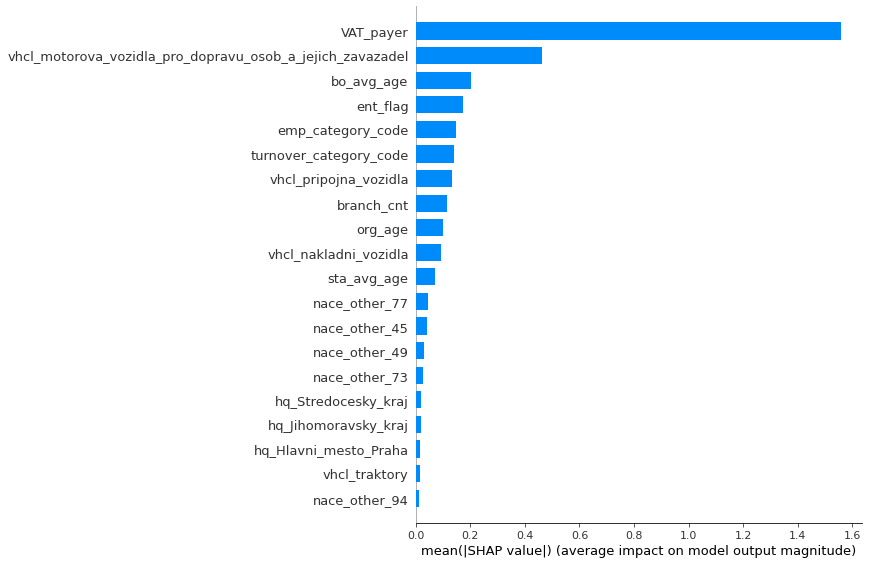

In [116]:
shap.summary_plot(shap_values, x, plot_type="bar")

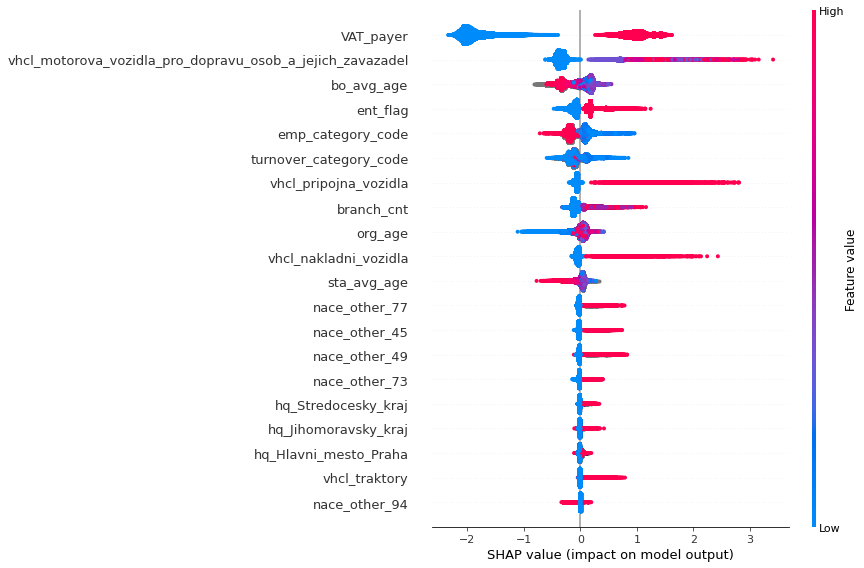

In [117]:
shap.summary_plot(shap_values, x)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


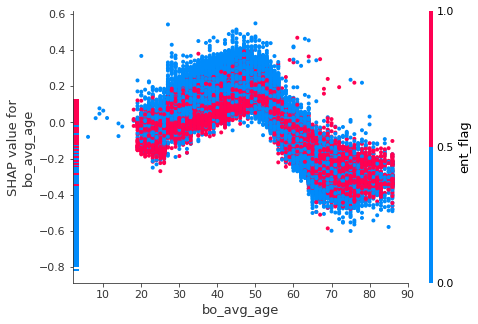

In [125]:
shap.dependence_plot("bo_avg_age", shap_values, x, interaction_index='ent_flag')